<a href="https://colab.research.google.com/github/Meshal6299/multilingual-movie-reviews-NLP/blob/main/notebooks/02_tokenization_ngram_pos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Meshal6299/multilingual-movie-reviews-NLP.git

Cloning into 'multilingual-movie-reviews-NLP'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 151 (delta 70), reused 95 (delta 33), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 5.41 MiB | 12.07 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [2]:
%cd multilingual-movie-reviews-NLP
!ls

# the output should be the following:
# /content/multilingual-movie-reviews-NLP
# data  notebooks  README.md  requirements.txt  run_pipeline.py  src

/content/multilingual-movie-reviews-NLP
data  notebooks  README.md  requirements.txt  run_pipeline.py  src


In [3]:
import spacy
import pandas as pd
import nltk
from nltk import ngrams
from collections import Counter
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 64.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
nlp_en = spacy.load("en_core_web_sm")
nlp_es = spacy.load("es_core_news_sm")

In [7]:
def tokenize_text(doc):
    return [token.text for token in doc if not token.is_punct and not token.is_space]

eng = pd.read_csv("./data/processed/01_cleaned_imdb_en.csv")
spa = pd.read_csv("./data/processed/01_cleaned_imdb_es.csv")

eng["tokens"] = eng["clean_text"].apply(lambda x: tokenize_text(nlp_en(x)))
spa["tokens"] = spa["clean_text"].apply(lambda x: tokenize_text(nlp_es(x)))

In [8]:
print(eng["tokens"].head())
print(spa["tokens"].head())

0    [feh, this, movie, started, out, in, an, inter...
1    [crackerjack, is, a, simple, but, feelgood, mo...
2    [this, star, studded, british, spanish, co, pr...
3    [my, wife, kate, and, i, absolutely, loved, th...
4    [unfortunately, this, film, is, typical, of, t...
Name: tokens, dtype: object
0    [feh, esta, película, comenzó, de, una, manera...
1    [crackerjack, es, una, película, sencilla, per...
2    [esta, coproducción, británica, española, de, ...
3    [mi, esposa, kate, y, yo, nos, encantó, la, se...
4    [desafortunadamente, esta, película, es, típic...
Name: tokens, dtype: object


In [9]:
# --- Compute tokenization statistics ---
avg_tokens_en = eng["tokens"].apply(len).mean()
avg_tokens_es = spa["tokens"].apply(len).mean()

total_tokens_en = sum(eng["tokens"].apply(len))
total_tokens_es = sum(spa["tokens"].apply(len))

vocab_size_en = len(set([word for tokens in eng["tokens"] for word in tokens]))
vocab_size_es = len(set([word for tokens in spa["tokens"] for word in tokens]))

In [10]:
token_stats = pd.DataFrame({
    "Language": ["English", "Spanish"],
    "Avg. Tokens per Review": [round(avg_tokens_en, 2), round(avg_tokens_es, 2)],
    "Total Tokens": [total_tokens_en, total_tokens_es],
    "Vocabulary Size": [vocab_size_en, vocab_size_es]
})

print("🧩 Tokenization Summary:\n")
display(token_stats)

🧩 Tokenization Summary:



,Language,Avg. Tokens per Review,Total Tokens,Vocabulary Size
0,English,230.85,461706,26796
1,Spanish,234.35,468704,41261


In [17]:
# Flatten token lists into one long list
tokens_en = [token for tokens in eng["tokens"] for token in tokens]
tokens_es = [token for tokens in spa["tokens"] for token in tokens]

# Create bigram models
bigrams_en = list(ngrams(tokens_en, 2))
bigrams_es = list(ngrams(tokens_es, 2))

# Count frequencies
model_en = Counter(bigrams_en)
model_es = Counter(bigrams_es)

In [12]:
def calculate_perplexity(model, test_tokens, n=2):
    N = len(test_tokens)
    ngrams_list = list(ngrams(test_tokens, n))
    total_count = sum(model.values())
    vocab_size = len(model)

    log_prob = 0
    for ng in ngrams_list:
        prob = (model[ng] + 1) / (total_count + vocab_size)  # Laplace smoothing
        log_prob += -math.log(prob)
    perplexity = math.exp(log_prob / N)
    return perplexity

# Use first 500 tokens as test data
test_en = tokens_en[:500]
test_es = tokens_es[:500]

pp_en = calculate_perplexity(model_en, test_en)
pp_es = calculate_perplexity(model_es, test_es)

print(f"English Perplexity: {pp_en:.2f}")
print(f"Spanish Perplexity: {pp_es:.2f}")


English Perplexity: 59954.07
Spanish Perplexity: 55483.99


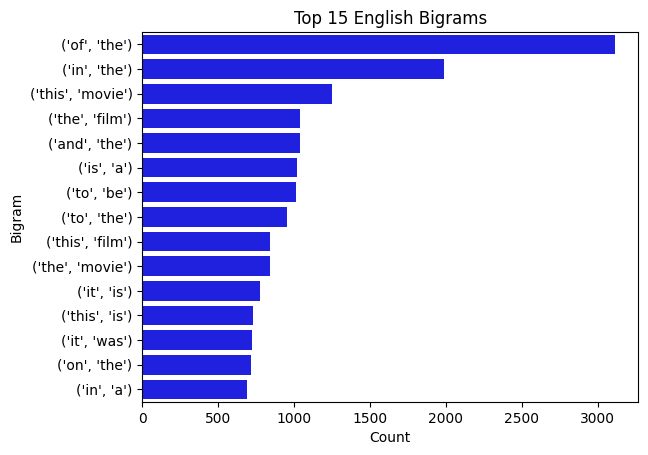

In [13]:
# Top 15 English bigrams
df_en = pd.DataFrame(model_en.most_common(15), columns=["Bigram", "Count"])
df_en["Bigram"] = df_en["Bigram"].astype(str)

sns.barplot(data=df_en, y="Bigram", x="Count", color="blue")
plt.title("Top 15 English Bigrams")
plt.show()

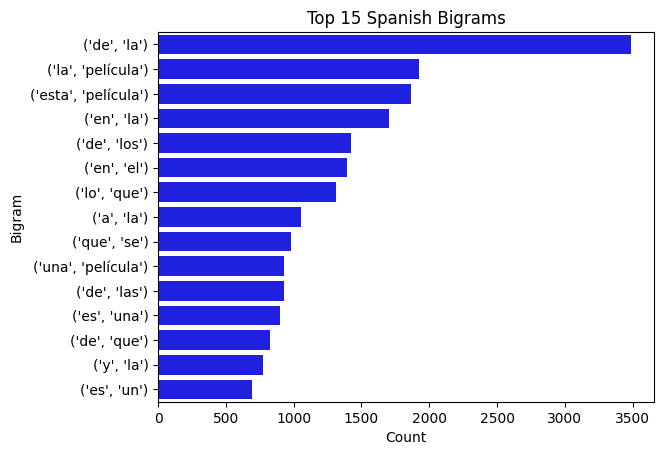

In [14]:
# Top 15 Spanish bigrams
df_es = pd.DataFrame(model_es.most_common(15), columns=["Bigram", "Count"])
df_es["Bigram"] = df_es["Bigram"].astype(str)

sns.barplot(data=df_es, y="Bigram", x="Count", color="blue")
plt.title("Top 15 Spanish Bigrams")
plt.show()